# Forecasting System - Project Demand of Products at a Retail Outlet Based on Historical Data

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas import Grouper
from statsmodels.tsa.stattools import adfuller
from numpy import log
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#importing the dataset
df = pd.read_csv("store_sales_data.csv")

In [3]:
#Displaying the dataframe
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
#Checking the shape af the dataset
df.shape

(913000, 4)

In [5]:
#Unique values in each column
df.nunique()

date     1826
store      10
item       50
sales     213
dtype: int64

In [6]:
#Datatypes of the features and target
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

**The original dataset is reduced**
* Sales data of single store (store 1) is taken for further analysis,
  forecasting and model building

In [7]:
#Store 1 data converted to separate dataframe
data = df[df['store']==1]

In [8]:
data.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [9]:
data.shape

(91300, 4)

In [10]:
data.nunique()

date     1826
store       1
item       50
sales     150
dtype: int64

In [11]:
#Droping the store column since only one datapoint in the column
data = data.drop('store',axis=1)

In [12]:
#Saving new dataframe to separate csv file
data.to_csv("data.csv")

In [13]:
data.head(5)

,date,item,sales
0,2013-01-01,1,13
1,2013-01-02,1,11
2,2013-01-03,1,14
3,2013-01-04,1,13
4,2013-01-05,1,10


In [14]:
#Converting the datatype of date to datetime format
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d') 

In [15]:
# Get the start and end date of the data
start_date = data['date'].min()
end_date = data['date'].max()

In [16]:
# Set the date column as the index of the dataframe
data = data.set_index('date')

In [17]:
data.head(5)

,item,sales
date,,
2013-01-01,1,13
2013-01-02,1,11
2013-01-03,1,14
2013-01-04,1,13
2013-01-05,1,10


In [18]:
# Create a series of all the days within the date range
all_days = pd.date_range(start_date, end_date, freq='D')
# Resample the data to daily frequency and take the sum of sales for each day
daily_data = data.resample('D').sum()

In [19]:
# Check for missing days
missing_days = daily_data[daily_data.isna().any(axis=1)]

In [20]:
# Print the missing days
print(missing_days)

Empty DataFrame
Columns: [item, sales]
Index: []


### Exploratory Data Analysis

**Itemwise descriptive statistics**

In [21]:
data.groupby('item')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
item,,,,,,,,
1,1826.0,19.971522,6.741022,4.0,15.00,19.0,24.00,50.0
2,1826.0,53.148959,15.005779,13.0,43.00,52.0,63.00,115.0
3,1826.0,33.208105,10.072529,8.0,26.00,33.0,40.00,70.0
4,1826.0,19.956188,6.640618,4.0,15.00,20.0,24.00,43.0
5,1826.0,16.612815,5.672102,3.0,13.00,16.0,20.00,37.0
6,1826.0,53.060789,14.826416,17.0,42.00,52.0,63.00,104.0
7,1826.0,52.783680,15.073838,14.0,42.00,52.0,63.00,115.0
8,1826.0,69.472070,18.751980,24.0,56.00,68.5,83.00,137.0
9,1826.0,46.504929,13.247496,14.0,37.00,46.0,55.00,94.0


**Overall Distribution of sales across 5 years**

Text(0, 0.5, 'sales frequency')

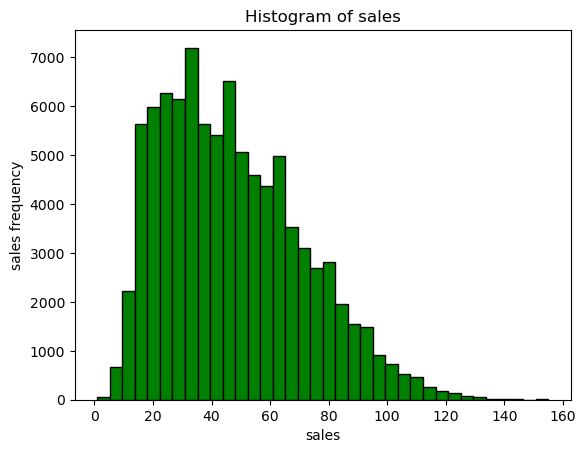

In [22]:
plt.hist(data['sales'], color = 'green', edgecolor = 'black', bins = int(180/5))
plt.title('Histogram of sales')
plt.xlabel('sales')
plt.ylabel('sales frequency')

**Itemwise daily sales plot**

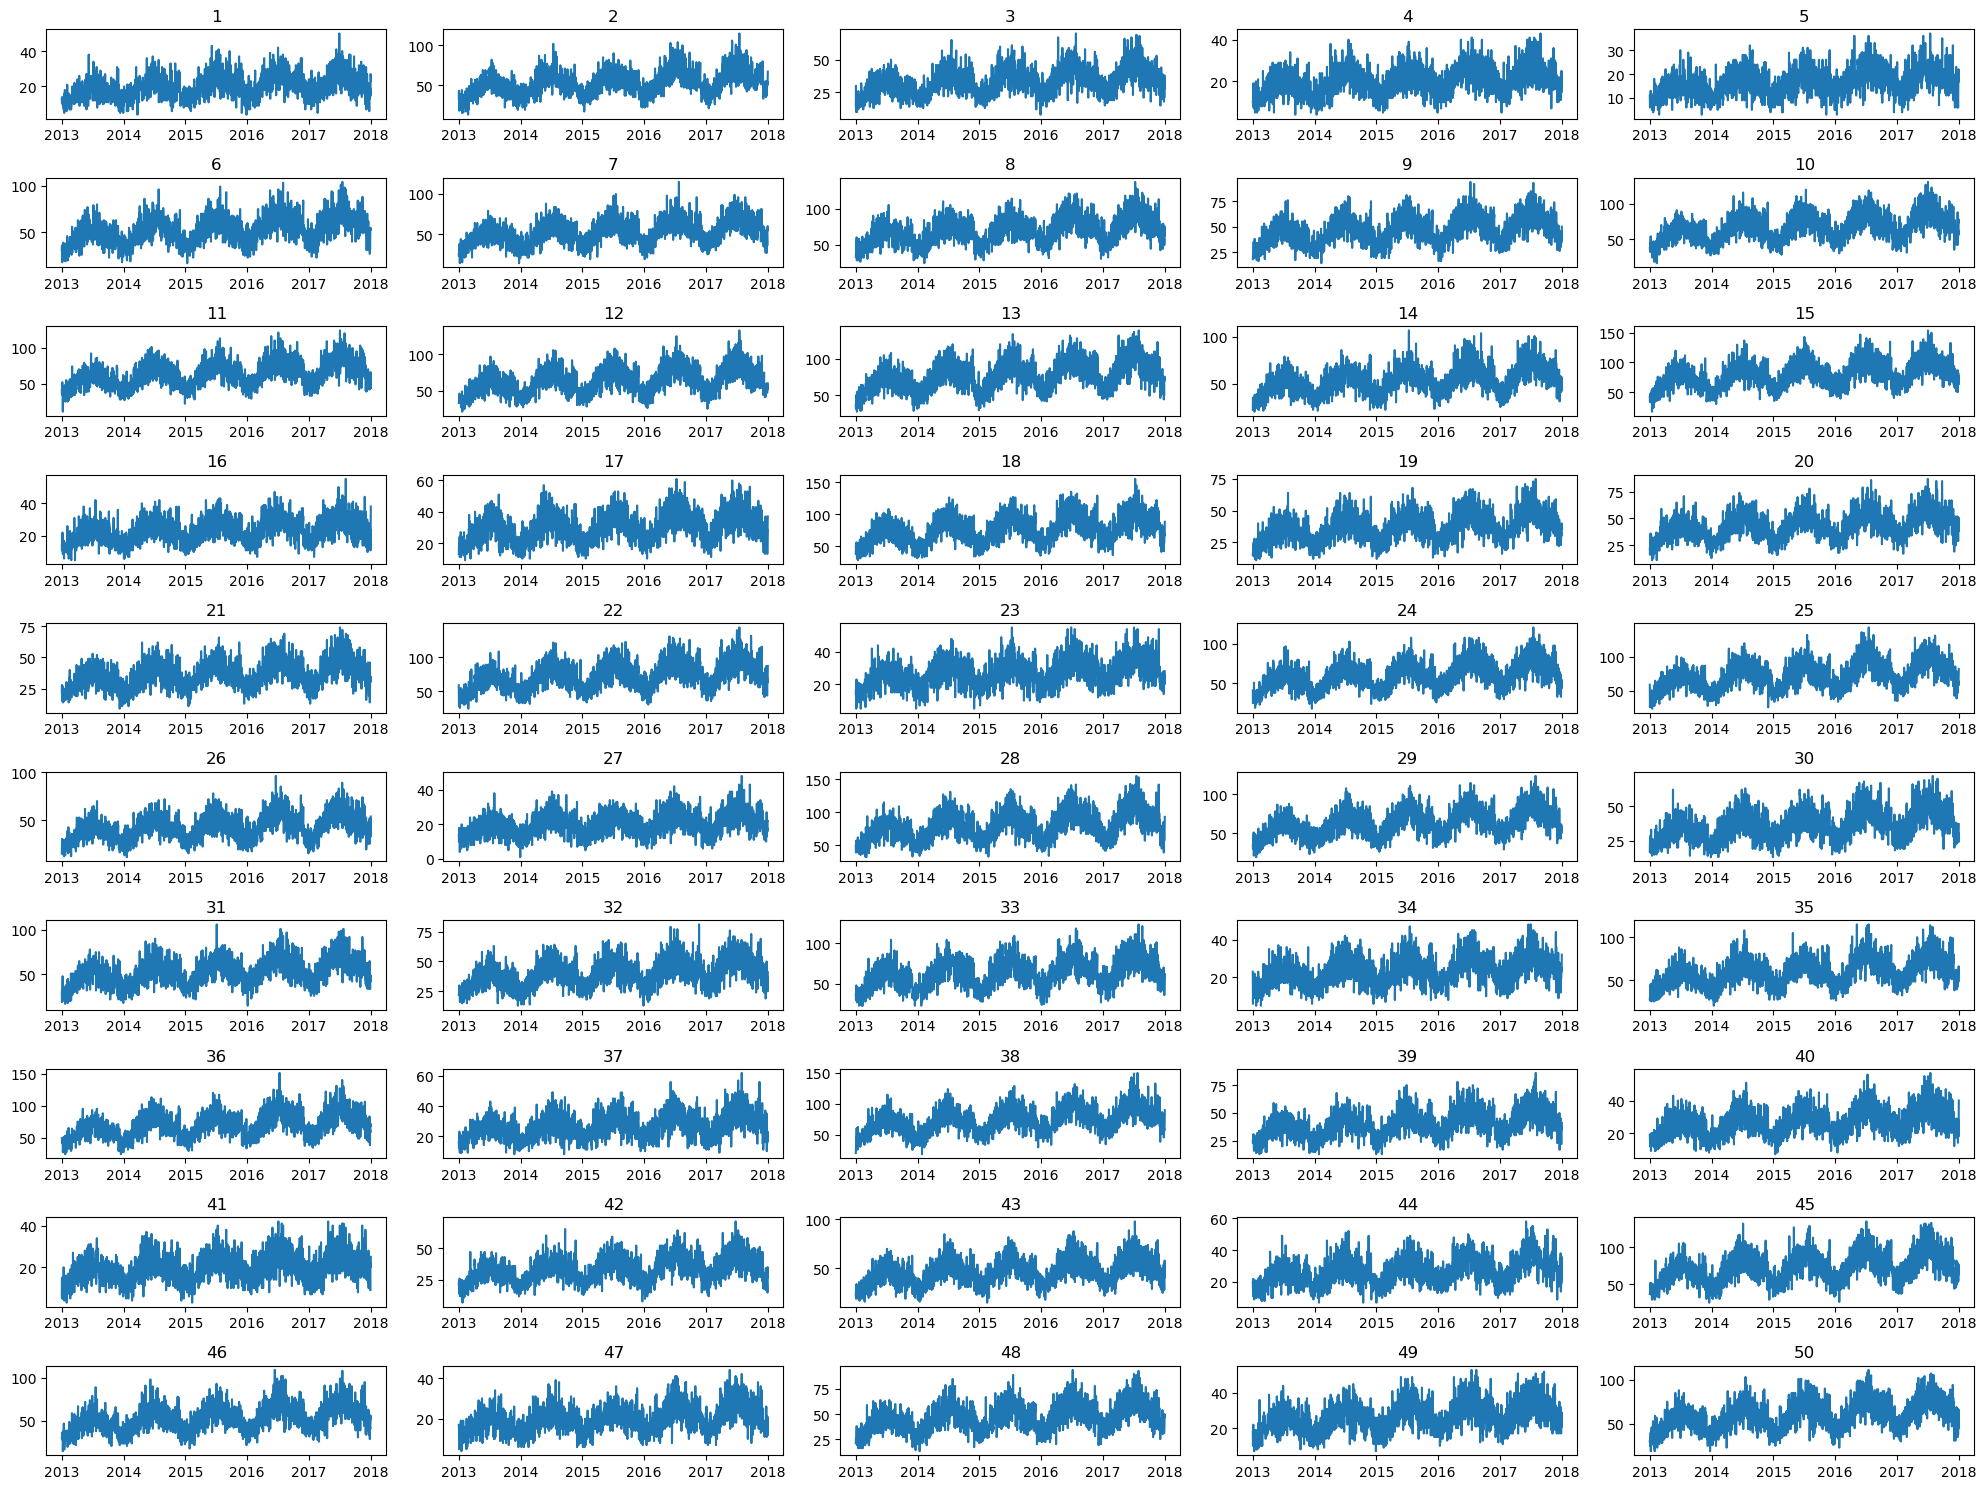

In [23]:
# Group the data by item
grouped = data.groupby('item')

# Create a figure with a specific size
fig, axs = plt.subplots(10, 5, figsize=(20,15))

# Flatten the array of axes
axs = axs.flatten()

# Loop over the groups and plot the sales for each item
for i, (item, group) in enumerate(grouped):
    axs[i].plot(group['sales'])
    axs[i].set_title(item)

# Tighten the layout to prevent overlapping
fig.tight_layout()

# Show the plot
plt.show()

**Monthly average sales**

In [24]:
#Resampling the data w.r.t months and taking sales average
monthly_sales = data.resample('M').mean()

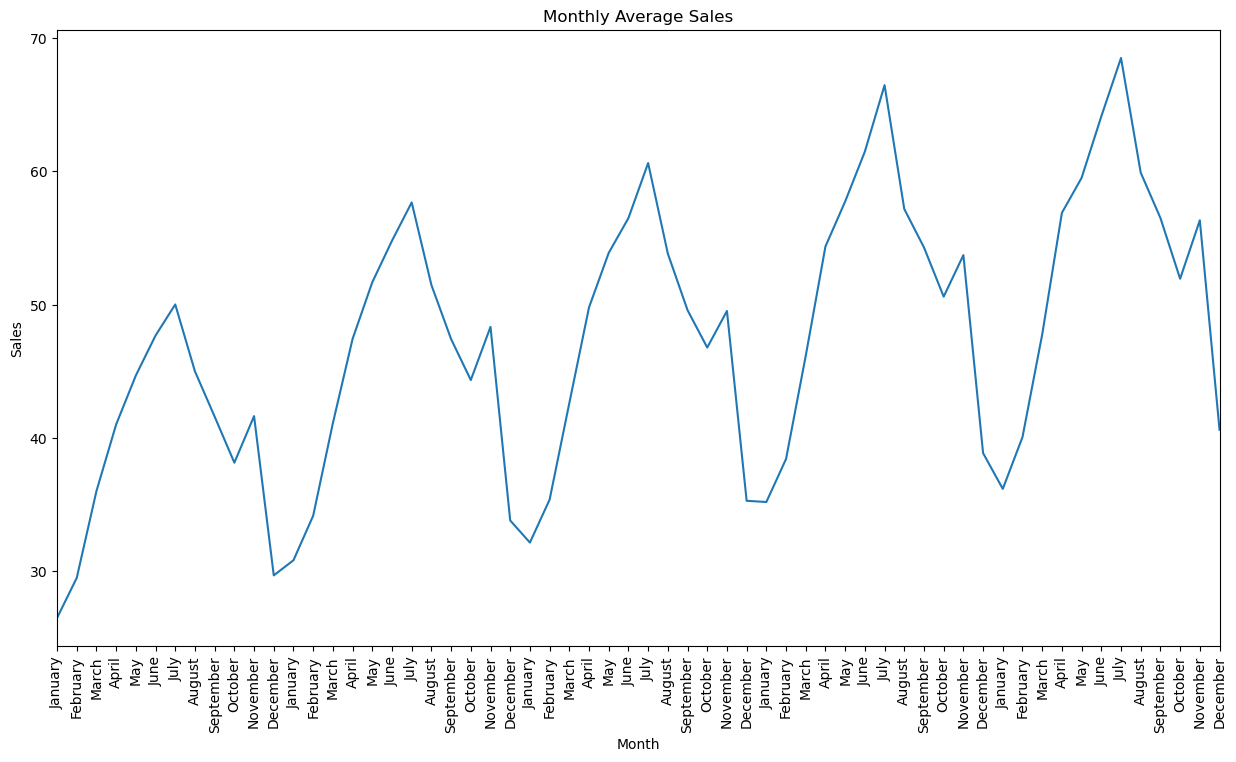

In [25]:
#Fetching the month names for labels 
month_labels = monthly_sales.index.strftime('%B')
plt.figure(figsize=(15,8))
monthly_sales['sales'].plot(kind='line')
plt.xticks(monthly_sales.index, month_labels, rotation=90)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Average Sales')
plt.show()

In [26]:
# Extract the day of the week from the date index and add it as a new column
data['day_of_week'] = data.index.dayofweek

**Average sales on a day of the week**

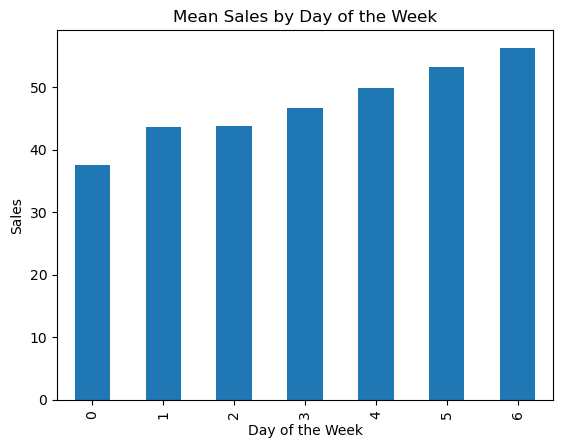

In [27]:
# Group the data by the day of the week and calculate the mean sales for each day
day_of_week_sales = data.groupby('day_of_week')['sales'].mean()

# Plot the mean sales by day of the week
day_of_week_sales.plot(kind='bar')

# Add labels and title to the plot
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.title('Mean Sales by Day of the Week')

# Show the plot
plt.show()


**Inferences from EDA**
1. The sales patterns for all the 50 items are almost similar and follow similar seasonal trend
2. There is a seasonal pattern in the sales. Each year the sales are less during the begining of the year,
   and it gradually increases and reach maximum on june-july months and then decreases towards the end of the year
3. Average sales is high on Saturdays and Sundays
4. No. of outliers and their magnitude in the sales for each item is comparitively very less, so they can be retained 


## Resampling the data into weekly sales
* The data is resampled to weekly sales to reduce the noise
* For demand forecasting usually weekly or monthly sales data is taken. 

In [28]:
data = pd.DataFrame(data.groupby('item')['sales'].resample('W').sum())

In [29]:
data.reset_index(inplace=True)

In [30]:
data = data.set_index('date')

In [31]:
data.head(5)

,item,sales
date,,
2013-01-06,1,73
2013-01-13,1,66
2013-01-20,1,80
2013-01-27,1,70
2013-02-03,1,86


## Feature Engineering

**Adding DateTime features**

In [32]:
data['year'] = data.index.year
data['month'] = data.index.month
data['week_of_year'] = data.index.weekofyear

In [33]:
data.head(5)

,item,sales,year,month,week_of_year
date,,,,,
2013-01-06,1,73,2013,1,1
2013-01-13,1,66,2013,1,2
2013-01-20,1,80,2013,1,3
2013-01-27,1,70,2013,1,4
2013-02-03,1,86,2013,2,5


**Note :**
* For further analysis only a single item (here item 1) is considered since all items follow similar 
pattern of sales.
* While fitting the final model all 50 items will be considered.

In [34]:
data_1 = data[data['item']==1]

Text(0.5, 1.0, 'Weekly Sales of Item 1 of Store 1')

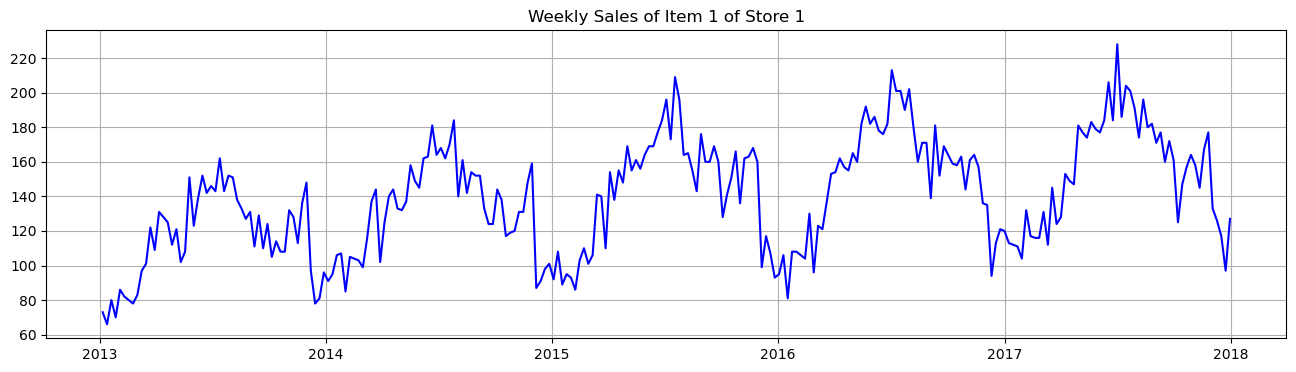

In [35]:
plt.figure(figsize=(16,4))
plt.plot(data_1['sales'],'b')
plt.grid()
plt.title('Weekly Sales of Item 1 of Store 1')

**Series Decomposition**

<Figure size 1200x1000 with 0 Axes>

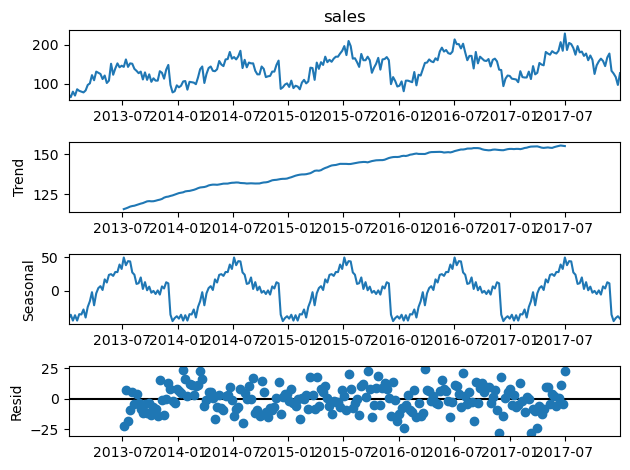

In [36]:
decomposition = sm.tsa.seasonal_decompose(data_1['sales'], model='additive',period=52)
plt.figure(figsize=(12,10))
decomposition.plot()
plt.show()

### Test for stationarity

***1. Rolling Statistics***

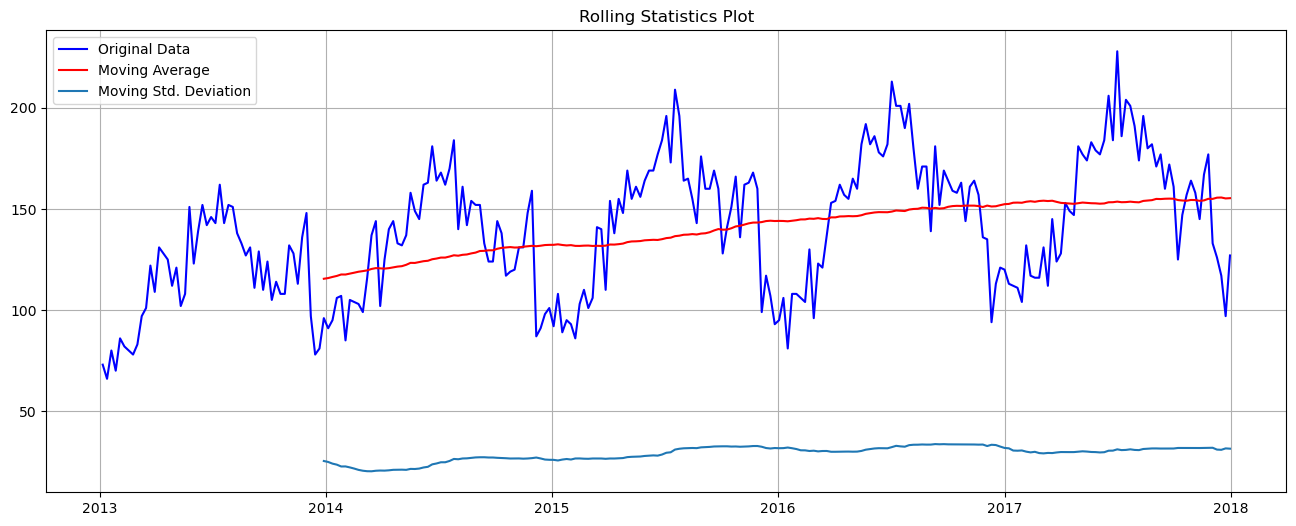

In [37]:
# Compute the moving average and moving standard deviation of the sales data

roll_mean = data_1['sales'].rolling(window=52).mean()
roll_std = data_1['sales'].rolling(window=52).std()

# Plot the original time series data and the moving average and variance
plt.figure(figsize=(16, 6))
plt.plot(data_1['sales'],'b', label='Original Data')
plt.plot(roll_mean,'r', label='Moving Average')
plt.plot(roll_std, label='Moving Std. Deviation')
plt.legend(loc='best')
plt.title('Rolling Statistics Plot')
plt.grid(True)
plt.show()


***2. Augmented Dickey Fuller test***

           Hypothesis for ADF test for stationarity :
 
            Ho : The series is not stationary

            H1 : The series is stationary

            level of significance: 0.05

In [38]:
# Results of ADF test
result = adfuller(data_1['sales'])
print('ADF Statistics : ',result[0])
print('p-value : ',result[1])

ADF Statistics :  -3.0753361483962967
p-value :  0.028433087450215576


***Inferences :***
1. p-value < 0.05, therefore null hypothesis can be rejected i.e the series is nearly stationary
   

**Spliting dataset into training and validation**

In [39]:
data_1_train = data_1.loc[:'2016-12-31']
data_1_val   = data_1.loc['2017-01-01':]

In [40]:
# Function to compute performance scores
def evaluate(real,predicted):
    # Calculate mean absolute error (MAE)
    mae = round(np.mean(np.abs(predicted - real)),2)

    # Calculate mean squared error (MSE)
    mse = round(np.mean((predicted - real)**2),2)
    
    # Calculate root mean squared error (RMSE)
    rmse = round(np.sqrt(mse),2)

    # Calculate mean absolute percentage error (MAPE)
    mape = round(np.mean(np.abs((real - predicted) / real)) * 100,2)

    # Create a Dataframe to display evalualion matrics values
    evaluate_df = pd.DataFrame({'MAE':mae,'RMSE':rmse,'MAPE':mape},index=['Score'])

    return evaluate_df
   

## Base Model - Holt Winter's Model

In [41]:
# create and fit the model to the training data
model_hw = ExponentialSmoothing(data_1_train['sales'], trend='mul', seasonal='add', seasonal_periods=52)
model_hw_fit = model_hw.fit()

#make prediction on training data
predict_hw = model_hw_fit.predict(start='2013-01-06',end='2016-12-31')

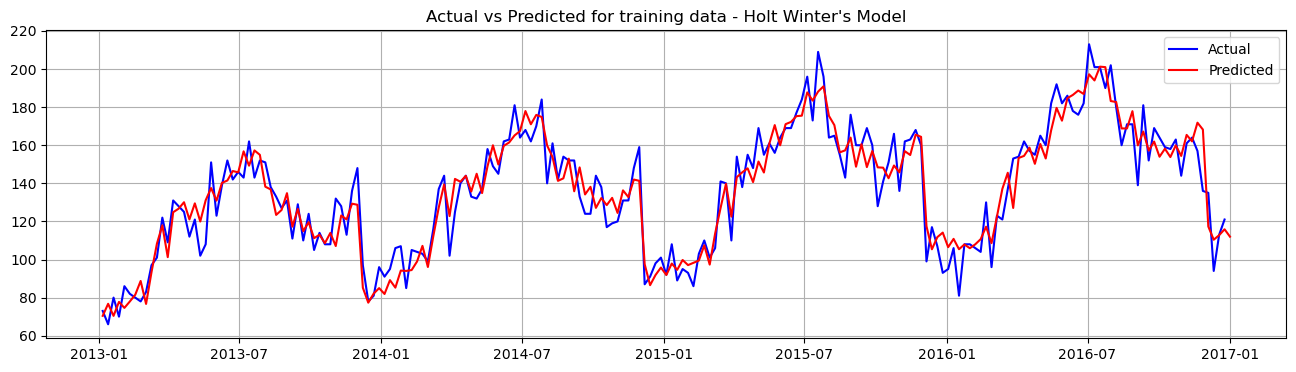

In [42]:
plt.figure(figsize=(16,4))
plt.plot(data_1_train['sales'],'b',label='Actual')
plt.plot(predict_hw,'r',label='Predicted')
plt.legend(loc='best')
plt.title("Actual vs Predicted for training data - Holt Winter's Model")
plt.grid()

**Model Evaluation**

In [43]:
#Calculating the performance metrics
evaluate(data_1_train['sales'],predict_hw)

,MAE,RMSE,MAPE
Score,8.31,10.31,6.47


**Model Validation**

In [44]:
# make predictions on the test data
forecast_hw = model_hw_fit.predict(start='2017-01-01',end='2017-12-31')

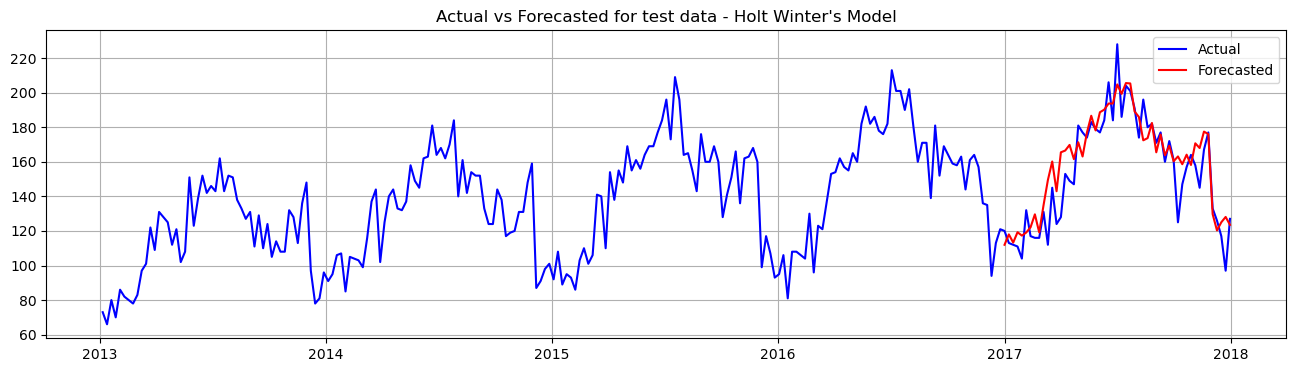

In [45]:
plt.figure(figsize=(16,4))
plt.plot(data_1['sales'],'b',label='Actual')
plt.plot(forecast_hw,'r',label='Forecasted')
plt.legend(loc='best')
plt.title("Actual vs Forecasted for test data - Holt Winter's Model")
plt.grid()

In [46]:
#Performance metrics on test data
evaluate(data_1_val['sales'],forecast_hw)

,MAE,RMSE,MAPE
Score,10.66,14.26,7.58


In [47]:
#Computing the residuals
res_hw = forecast_hw - data_1_val['sales']

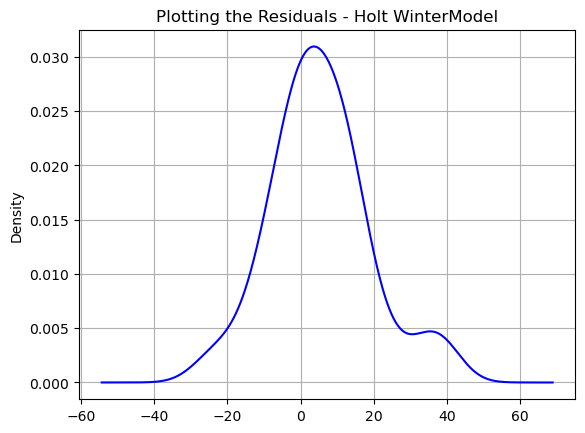

In [48]:
#Plotting the residuals
res_hw.plot(kind='kde',color='blue')
plt.title('Plotting the Residuals - Holt WinterModel')
plt.grid()

**Auto Correlation Funtion(ACF) and Passive Autocorrelation Function(PACF)**

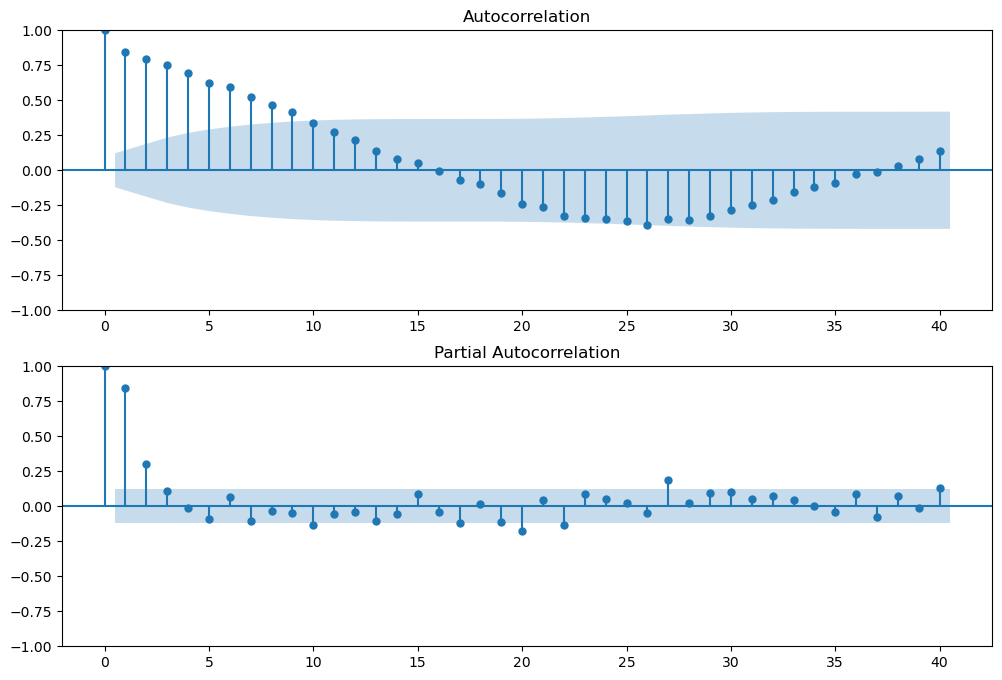

In [49]:
# Plotting ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_1['sales'],lags = 40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_1['sales'],lags = 40,ax=ax2)

## ARMA Model

In [50]:
#Building an ARMA model with p=2,d=0 and q=9
model_arma = sm.tsa.ARIMA(data_1_train['sales'], order=(2, 0, 9))
model_arma_fit = model_arma.fit()
print(model_arma_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  208
Model:                 ARIMA(2, 0, 9)   Log Likelihood                -868.918
Date:                Tue, 28 Feb 2023   AIC                           1763.836
Time:                        16:54:01   BIC                           1807.224
Sample:                    01-06-2013   HQIC                          1781.380
                         - 12-25-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.2041      8.014     16.745      0.000     118.496     149.912
ar.L1          1.4137      0.363      3.895      0.000       0.702       2.125
ar.L2         -0.5489      0.306     -1.794      0.0

**Model Evaluation**

In [51]:
# Model evaluation on training set
predict_arma = model_arma_fit.predict()
evaluate(data_1_train['sales'],predict_arma)

,MAE,RMSE,MAPE
Score,12.03,16.13,9.72


**Plotting the predictions**

Text(0.5, 1.0, 'Actual vs Predicted Sales on training data (ARMA Model)')

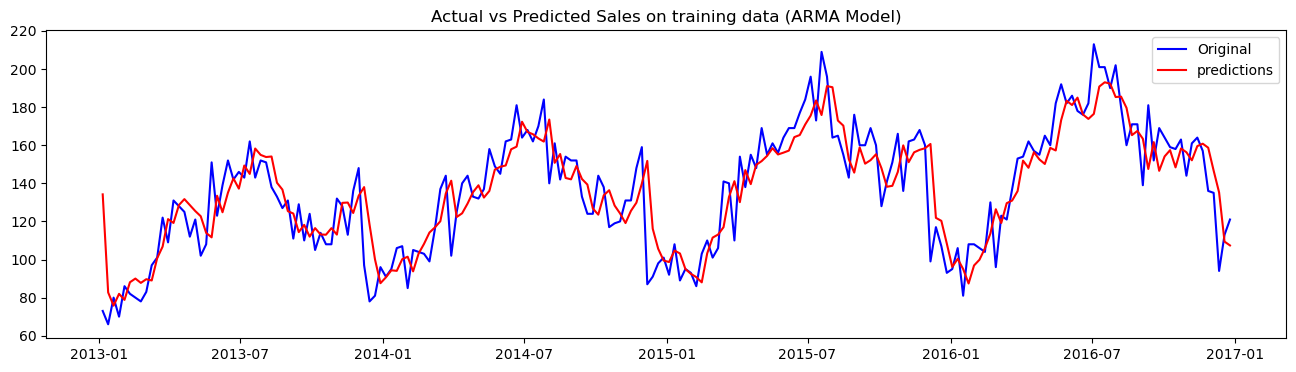

In [52]:
plt.figure(figsize=(16,4))
plt.plot(data_1_train['sales'],'b',label='Original')
plt.plot(predict_arma,'r',label='predictions')
plt.legend(loc='best')
plt.title('Actual vs Predicted Sales on training data (ARMA Model)')

**Forecasting on validation set and plotting the forecast**

In [53]:
# Setting the start and end date for forecasting w.r.t the test dataset
start_date = '2017-01-01'
end_date = '2017-12-31'
forecast_arma = model_arma_fit.predict(start=start_date,end=end_date)

Text(0.5, 1.0, 'Actual vs Predicted Sales on test data (ARMA Model)')

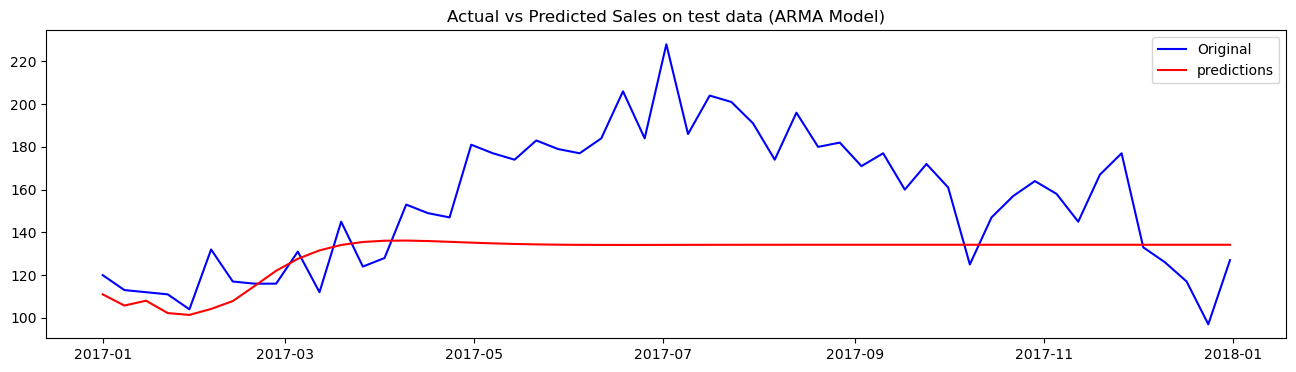

In [54]:
# Plotting the forecast
plt.figure(figsize=(16,4))
plt.plot(data_1_val['sales'],'b',label='Original')
plt.plot(forecast_arma,'r',label='predictions')
plt.legend(loc='best')
plt.title('Actual vs Predicted Sales on test data (ARMA Model)')

In [55]:
evaluate(data_1_val['sales'],forecast_arma)

,MAE,RMSE,MAPE
Score,29.54,36.62,17.44


**Inferences:**
* The ARMA model was not able to capture the seasonality


## ARIMA Model

* The ADF test showed that the series is stationary, but the series decomposition plots indicated a trend as well as a strong annual seasonality.

* Also the rolling statistic test indicated a gradual increase in the mean over time, therefore the first difference of the series is taken to make it stationary.

<Figure size 1600x400 with 0 Axes>

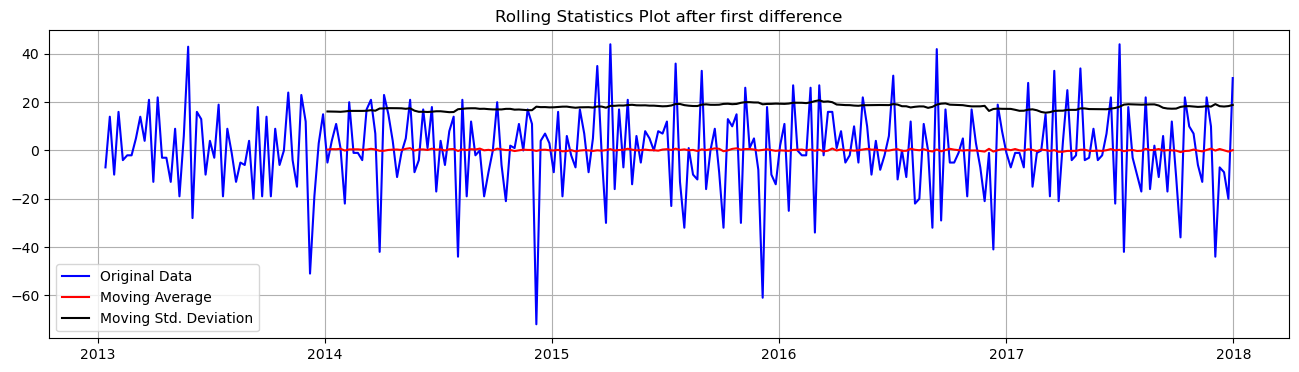

In [56]:
# Taking the first difference of sales and computing rolling statistics
fig = plt.figure(figsize=(16,4))
roll_mean = data_1['sales'].diff().dropna().rolling(window=52).mean()
roll_std = data_1['sales'].diff().dropna().rolling(window=52).std()

# Plot the original time series data and the moving average and variance
plt.figure(figsize=(16, 4))
plt.plot(data_1['sales'].diff(),'b', label='Original Data')
plt.plot(roll_mean,'r', label='Moving Average')
plt.plot(roll_std,color='black' ,label='Moving Std. Deviation')
plt.legend(loc='best')
plt.title('Rolling Statistics Plot after first difference')
plt.grid(True)
plt.show()

* The data has become highly stationary when the first difference is taken

In [57]:
# Fitting ARIMA model with p=1,q=1 and d=1
model_arima = sm.tsa.ARIMA(data_1_train['sales'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  208
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -870.654
Date:                Tue, 28 Feb 2023   AIC                           1747.307
Time:                        16:54:02   BIC                           1757.305
Sample:                    01-06-2013   HQIC                          1751.350
                         - 12-25-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0571      0.177     -0.323      0.747      -0.404       0.290
ma.L1         -0.3582      0.169     -2.123      0.034      -0.689      -0.028
sigma2       263.3146     20.390     12.914      0.0

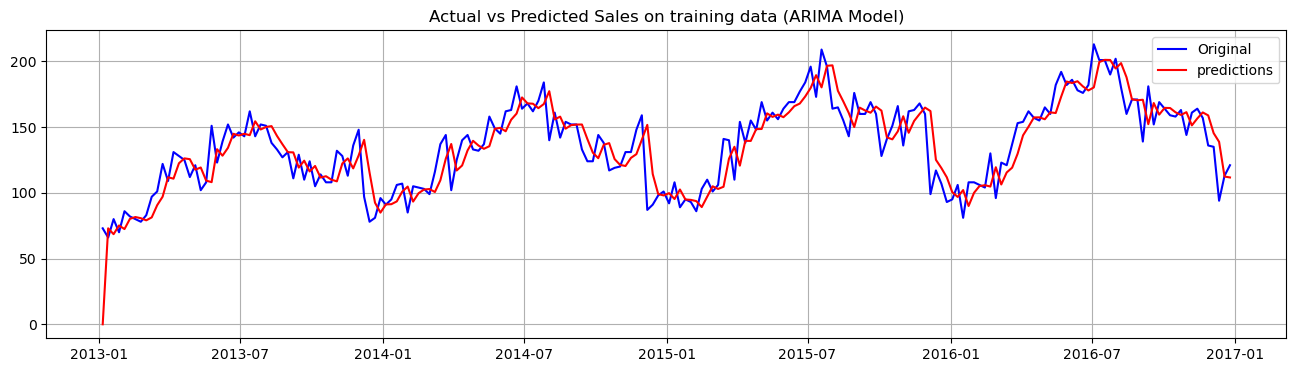

In [58]:
#Plotting the predictions
predict_arima = model_arima_fit.predict()
plt.figure(figsize=(16,4))
plt.plot(data_1_train['sales'],'b',label='Original')
plt.plot(predict_arima,'r',label='predictions')
plt.legend(loc='best')
plt.title('Actual vs Predicted Sales on training data (ARIMA Model)')
plt.grid()

**Model Evaluation**

In [59]:
evaluate(data_1_train['sales'],predict_arima)

,MAE,RMSE,MAPE
Score,12.29,16.96,9.92


**Moldel Validation on test set**

In [60]:
#Setting time frame of test data
start_date = '2017-01-01'
end_date = '2017-12-31'
#Forecating 
forecast_arima = model_arima_fit.predict(start=start_date,end=end_date)

Text(0.5, 1.0, 'Actual vs Predicted Sales on test data (ARIMA Model)')

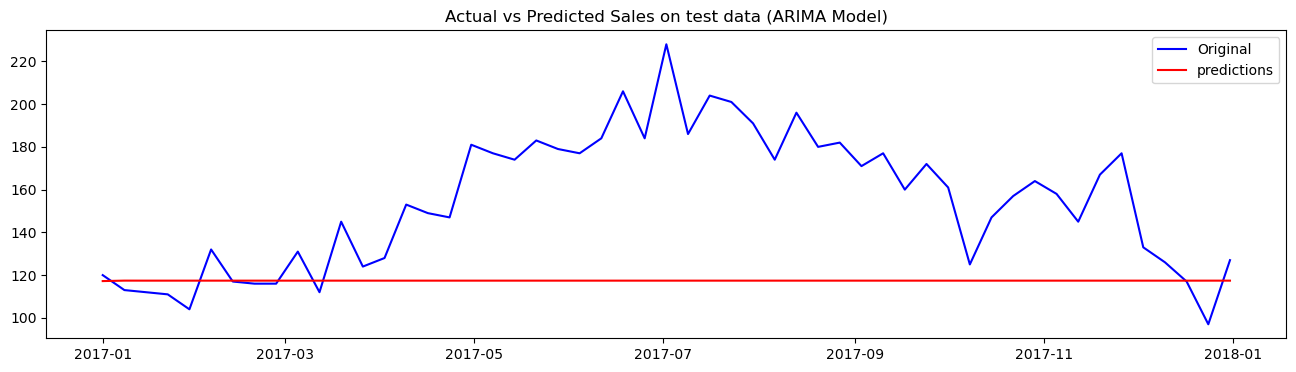

In [61]:
# Plotting Forecasted data and real test data
plt.figure(figsize=(16,4))
plt.plot(data_1_val['sales'],'b',label='Original')
plt.plot(forecast_arima,'r',label='predictions')
plt.legend(loc='best')
plt.title('Actual vs Predicted Sales on test data (ARIMA Model)')

In [62]:
evaluate(data_1_val['sales'],forecast_arima)

,MAE,RMSE,MAPE
Score,39.5,48.61,22.89


## SARIMA Model

In [63]:
order = (1,1,2)
seasonal_order = (2,0,2,52)

In [64]:
model_sarima = SARIMAX(data_1_train['sales'],order=order,seasonal_order=seasonal_order,enforce_stationarity=False)

In [65]:
model_sarima_fit = model_sarima.fit()

**Model Evaluation**

In [66]:
predict_sarima = model_sarima_fit.predict()
evaluate(data_1_train['sales'],predict_sarima)

,MAE,RMSE,MAPE
Score,12.23,16.21,9.76


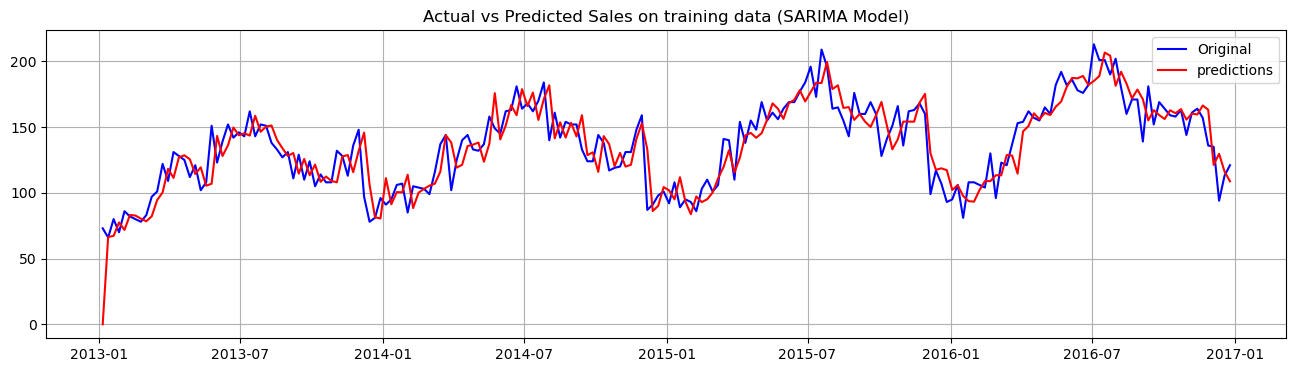

In [67]:
#Plotting predictions 
predict_sarima = model_sarima_fit.predict()
plt.figure(figsize=(16,4))
plt.plot(data_1_train['sales'],'b',label='Original')
plt.plot(predict_sarima,'r',label='predictions')
plt.legend(loc='best')
plt.title('Actual vs Predicted Sales on training data (SARIMA Model)')
plt.grid()

**Model validation on test data**

In [68]:
#Forecasting for validation time frame
start_date = '2017-01-01'
end_date = '2017-12-31'
forecast_sarima = model_sarima_fit.predict(start=start_date,end=end_date)

In [69]:
evaluate(forecast_sarima,data_1_val['sales'])

,MAE,RMSE,MAPE
Score,12.65,15.9,8.29


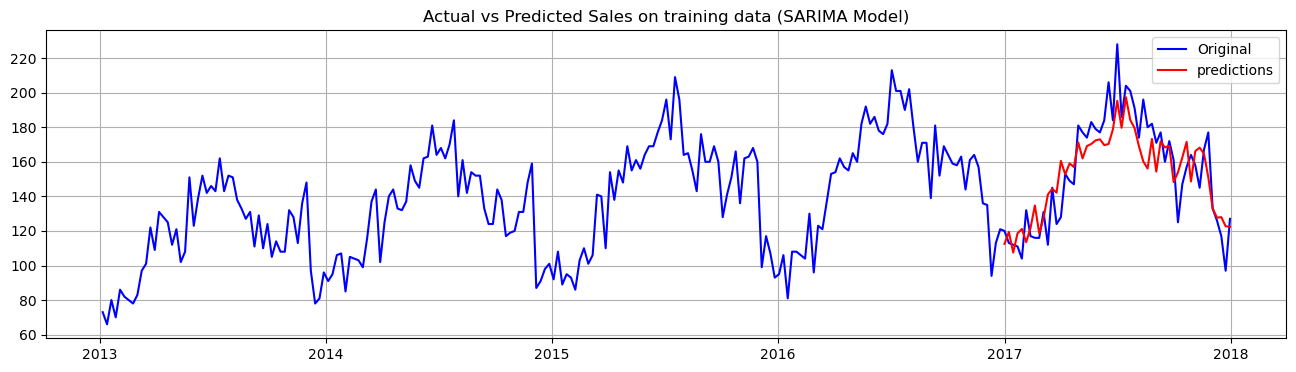

In [70]:
#Plotting the forecast
plt.figure(figsize=(16,4))
plt.plot(data_1['sales'],'b',label='Original')#,marker='o')
plt.plot(forecast_sarima,'r',label='predictions')#,marker='o')
plt.legend(loc='best')
plt.title('Actual vs Predicted Sales on training data (SARIMA Model)')
plt.grid()

**Grid Searching for best Hyperparameters**
* Grid searching was done to iterate through different valus of (p,d,q) and (P,D,Q,m) to find and optimal parameter set, so that the RMSE Score is minimum


**Ploting the residuals**

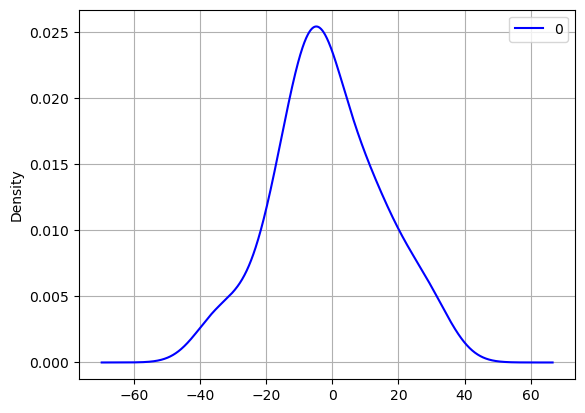

In [71]:
residuals_sarima = pd.DataFrame(forecast_sarima-data_1_val['sales'])
residuals_sarima.plot(kind='kde',color='blue')
plt.grid()

**Rolling Forecast Analysis**

**Plotting the residuals**

In [72]:
residuals_sarima = pd.DataFrame(predict_sarima_df[0]-data_1_val['sales'])
residuals_sarima.plot(kind='kde',color='blue')
plt.grid()

NameError: name 'predict_sarima_df' is not defined

# FbProphet Model

In [73]:
data_1_train_prophet = data_1_train[data_1_train['item']==1]

In [74]:
data_1_train_prophet = data_1_train_prophet.reset_index()

In [75]:
data_1_train_prophet.head(5)

,date,item,sales,year,month,week_of_year
0,2013-01-06,1,73,2013,1,1
1,2013-01-13,1,66,2013,1,2
2,2013-01-20,1,80,2013,1,3
3,2013-01-27,1,70,2013,1,4
4,2013-02-03,1,86,2013,2,5


In [76]:
# Preparing the dataframe to use prophet
data_1_train_prophet.columns = ['ds','item','y','year','month','week_of_year']

In [77]:
data_1_train_prophet.head(5)

,ds,item,y,year,month,week_of_year
0,2013-01-06,1,73,2013,1,1
1,2013-01-13,1,66,2013,1,2
2,2013-01-20,1,80,2013,1,3
3,2013-01-27,1,70,2013,1,4
4,2013-02-03,1,86,2013,2,5


In [78]:
data_1_train_prophet.shape

(208, 6)

In [79]:
#Building the model
model_prophet = Prophet()
model_prophet.fit(data_1_train_prophet)

16:54:31 - cmdstanpy - INFO - Chain [1] start processing
16:54:31 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
#Creating future dates for forecasting on validation set
future_dates = model_prophet.make_future_dataframe(periods=53, freq='W')

In [81]:
#Making predictions on future dates
prediction_prophet = model_prophet.predict(future_dates)

Text(0.5, 1.0, 'Actual vs Predictions - Prophet Model')

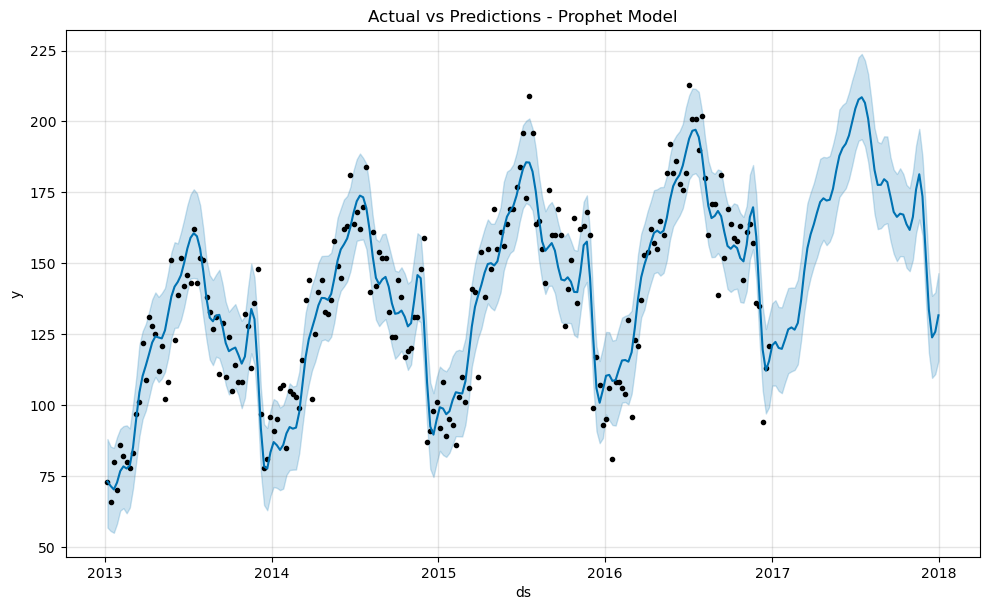

In [82]:
#Plotting the predictions
model_prophet.plot(prediction_prophet)
plt.title("Actual vs Predictions - Prophet Model")

In [83]:
#Cross validation
data_prophet_cv = cross_validation(model_prophet,initial='52W',period='26W',horizon='52W')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/4 [00:00<?, ?it/s]

16:54:32 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] done processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] done processing
16:54:34 - cmdstanpy - INFO - Chain [1] start processing
16:54:34 - cmdstanpy - INFO - Chain [1] done processing
16:54:34 - cmdstanpy - INFO - Chain [1] start processing
16:54:34 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
data_prophet_metrics = performance_metrics(data_prophet_cv)

In [85]:
data_prophet_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,35 days,338.204140,18.390327,15.527198,0.131885,0.104013,0.121871,0.45
1,42 days,341.241781,18.472731,15.076263,0.132371,0.104013,0.120910,0.50
2,49 days,359.569007,18.962305,15.999984,0.141167,0.104374,0.129009,0.40
3,56 days,230.945456,15.196890,12.994335,0.109747,0.093095,0.102436,0.55
4,63 days,269.058552,16.403004,13.858260,0.120810,0.100799,0.111658,0.55
5,70 days,228.037815,15.100921,12.772411,0.111028,0.093095,0.103342,0.60
6,77 days,217.351836,14.742857,12.832524,0.104355,0.086008,0.098744,0.65
7,84 days,253.428410,15.919435,13.728563,0.106510,0.086008,0.102161,0.60
8,91 days,335.038984,18.304070,15.691187,0.123139,0.107657,0.117018,0.50
9,98 days,264.749833,16.271135,13.428736,0.101400,0.081988,0.097706,0.60


**Model Validation**

In [86]:
prophet_forecast = prediction_prophet['yhat'].tail(53).astype(int)
prophet_forecast.index = data_1_val['sales'].index

In [87]:
evaluate(prophet_forecast,data_1_val['sales'])

,MAE,RMSE,MAPE
Score,12.53,16.01,7.79


In [88]:
#Computing the residues
prophet_residue = prophet_forecast-data_1_val['sales']

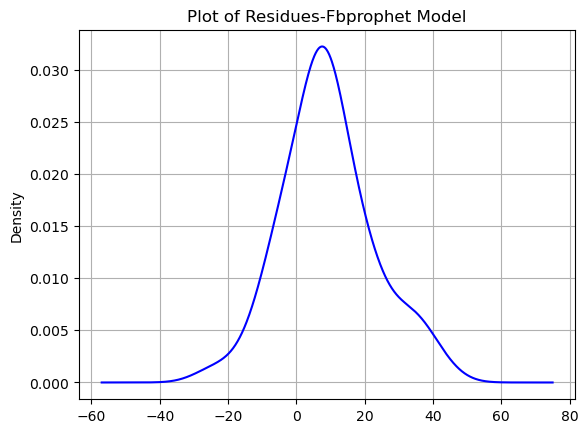

In [89]:
#Plotting the residues
prophet_residue.plot(kind='kde',color='blue')
plt.title('Plot of Residues-Fbprophet Model')
plt.grid()

## Comparing the Models

In [90]:
df_HW = evaluate(forecast_hw,data_1_val['sales'])
df_sarima= evaluate(forecast_sarima,data_1_val['sales'])
df_prophet = evaluate(prophet_forecast,data_1_val['sales'])

In [91]:
df_compare = pd.concat([df_HW,df_sarima,df_prophet],ignore_index=True)
df_compare.index = ['Holt Winters','SARIMA','Prophet']

In [92]:
df_compare

,MAE,RMSE,MAPE
Holt Winters,10.66,14.26,6.83
SARIMA,12.65,15.90,8.29
Prophet,12.53,16.01,7.79


Text(0.5, 1.0, 'Model Comparison')

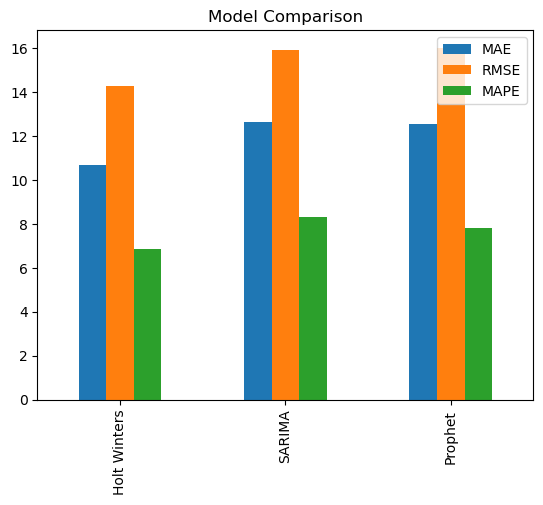

In [93]:
df_compare.plot(kind='bar')
plt.title('Model Comparison')

**Building the model for entire dataset of 50 items in Store 1**

In [94]:
#Creating a new column 'predictions' in the dataframe
data['prediction'] = np.nan

In [108]:
# create and fit the model to the training data
for i in range(1,51):
    model_final = ExponentialSmoothing(data[data['item']==i]['sales'], trend='mul', seasonal='add', seasonal_periods=52)
    model_final_fit = model_final.fit()
    predict_final = model_final_fit.predict(start='2013-01-06',end='2017-12-31')
    data.loc[data['item'] == i, 'prediction'] = predict_final.values

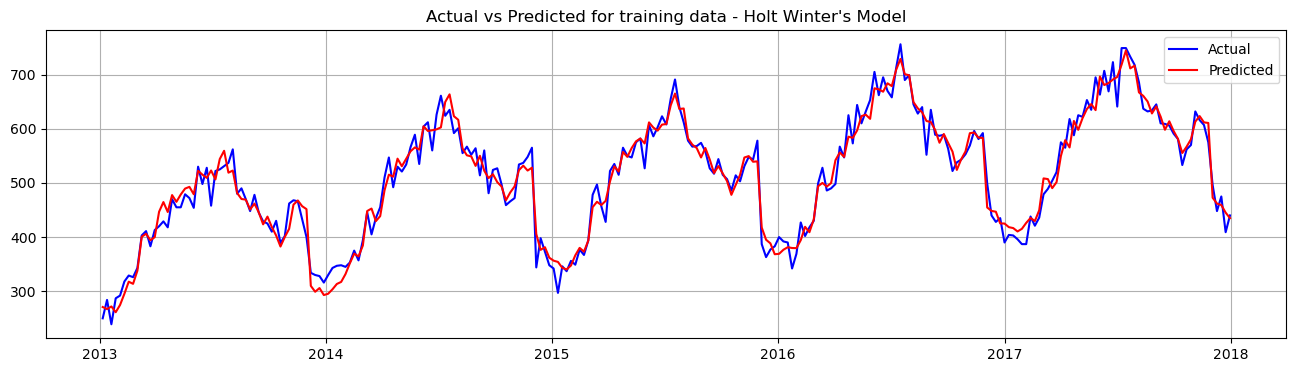

In [109]:
#Checking the model on a random item 
plt.figure(figsize=(16,4))
plt.plot(data[data['item']==25]['sales'],'b',label='Actual')
plt.plot(data[data['item']==25]['prediction'],'r',label='Predicted')
plt.legend(loc='best')
plt.title("Actual vs Predicted for training data - Holt Winter's Model")
plt.grid()

**Results**


* Holt Winter’s, ARMA, ARIMA, SARIMA and Prophet models were used. In this only Holt-Winter’s, SARIMA and Prophet were able to capture the trend and seasonality of the data.

* These 3 models were compared based on their performance on validation data using MAE, RMSE and MAPE metrics.

* Holt-winter’s model performed better for the data used for this project.  
